In [68]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt



In [62]:
def get_CSI(CSI_RAW): # Function to extract the CSI information from CSV file rows
    string = CSI_RAW
    res = string.split(' ')
    numbers = []
    for token in res:
        if '[' in token or ']' in token:
            if '[' in token:
                temp = token.split('[')
                if len(temp[1]) > 0:
                    number = int(temp[1])
                    numbers.append(number)
            if ']' in token:
                temp = token.split(']')
                if len(temp[1]) > 0:
                    number = int(temp[1])
                    numbers.append(number)
        else:
            number = int(token)
            numbers.append(number)
    return numbers

In [ ]:
CSV_FILE_LABELS = ['entrance', 'infront', '2ndrow']
preamble = '../data/lab_'

n_classes = len(CSV_FILE_LABELS)
CSI_dim = 128

target_mac = "3A:FB:99:B4:E0:FC" # replace with your target device mac

datas = []
n_data_total = 0 
n_datas = []
for label in CSV_FILE_LABELS:
    filename = preamble + label + '.csv'
    df = pd.read_csv(filename)

    df = df.drop(columns='CSI_DATA') # Drop these when fixed
    df = df.rename(columns={'seq_ctrl': 'CSI'})

    df = df[['mac', 'rssi', 'CSI']] # Relevant columns
    df = df[df['mac'] == target_mac] # Take only target mac address into account

    data = df[['CSI']].to_numpy()
    datas.append(data)

    n_data = len(data)
    n_datas.append(n_data)
    n_data_total += n_data

X = np.zeros((n_data_total, CSI_dim)) # Features
Y = np.zeros((n_data_total, n_classes)) # Labels

start_index = 0
for i, data in enumerate(datas):
    for j, value in enumerate(data):
        string = value[0]
        X[start_index + j,:] = np.array(get_CSI(string))
        Y[start_index + j,i] = 1
    start_index += n_datas[i]

In [64]:
# shuffle inputs
indsh = (np.arange(n_data_total))
np.random.shuffle(indsh)

X = X[indsh, :]
Y = Y[indsh]

X_train = X[:int(0.7 * n_data_total),:]
y_train = Y[:int(0.7 * n_data_total),:]

X_val = X[int(0.7 * n_data_total):int(0.8 * n_data_total),:]
y_val = Y[int(0.7 * n_data_total):int(0.8 * n_data_total),:]

X_test = X[int(0.8 * n_data_total):,:]
y_test = Y[int(0.8 * n_data_total):,:]

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        x = self.feature[idx, :]
        y = self.label[idx, :]
        return x, y

# Create Dataset objects
train_data = CustomDataset(torch.Tensor(X_train), torch.Tensor(y_train))
val_data = CustomDataset(torch.Tensor(X_val), torch.Tensor(y_val))
test_data = CustomDataset(torch.Tensor(X_test), torch.Tensor(y_test))

# Create DataLoader for training, validation, and test sets
batch_size = 4
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [65]:
shared_layers = nn.Sequential(
    nn.Linear(CSI_dim, 256, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, 64, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Linear(64, 32, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(32),
    nn.Linear(32, 16, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(16),
    nn.Linear(16, 4, bias=True),
    nn.ReLU(),
    nn.BatchNorm1d(4),
    nn.Linear(4, n_classes, bias=True) # Last dim is the amount classes / locations
)

class My_NN(nn.Module):
        def __init__(self):
            super(My_NN, self).__init__()
            self.block = shared_layers

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_uniform_(m.weight)
                    nn.init.zeros_(m.bias)
                elif isinstance(m, nn.BatchNorm1d):
                    nn.init.ones_(m.weight)
                    nn.init.zeros_(m.bias)

        def forward(self, feature):  # input feature matrix size: CSI_dim = 128
            output1 = self.block(feature)

            return output1

100%|██████████| 100/100 [00:38<00:00,  2.61it/s]


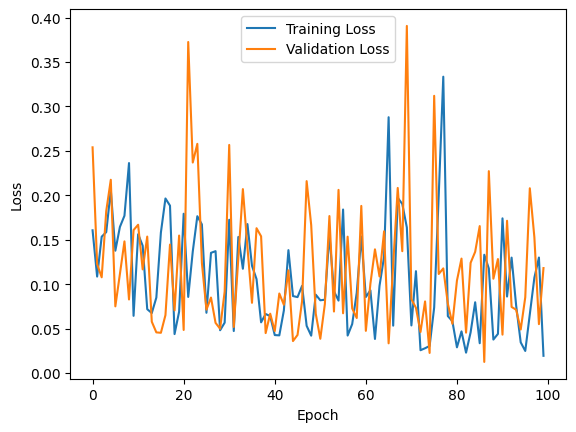

In [66]:
# Initialize the model and other hyperparameters
my_nn = My_NN()
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.SGD(my_nn.parameters(), lr=0.001, momentum=0.9)

my_nn.train()
num_epochs = 100
print_parameters_every = 20  # Print parameters every n epochs
train_losses = []
validation_losses = []
for epoch in tqdm(range(num_epochs)):
    for feature_batch, labels_batch in train_loader:  
        output = my_nn(feature_batch)  
        loss = criterion(output, labels_batch)  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(loss.item())  # Store training loss
    # validation loop
    with torch.no_grad():
        for feature_batch, labels_batch in val_loader:
            output = my_nn(feature_batch)
            val_loss = criterion(output, labels_batch)
            # scheduler.step(val_loss)  # you may add the scheduler to avoid over-fitting by reducing learning rate

        validation_losses.append(val_loss.item())
# Plot the training and validation loss
plt.figure(1)
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [67]:
# test loop
my_nn.eval()
correct = 0
total = 0
with torch.no_grad():
    for feature_batch, labels_batch in test_loader:
        out = my_nn(feature_batch)
        _,pred = torch.max(out,1)
        _, real = torch.max(labels_batch,1)
        total += len(real)
        correct += (pred == real).sum().item()

print("Accuracy:", correct/total)

Accuracy: 0.919921875
